In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
def load_data():
    train = pd.read_csv('C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/test.csv')

    train_dir = os.path.join('C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/','train_images/')
    test_dir = os.path.join('C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/','test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [3]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)
df_train['diagnosis']

(3662, 4) (1928, 3) 



0       2
1       4
2       1
3       0
4       0
       ..
3657    2
3658    0
3659    2
3660    0
3661    2
Name: diagnosis, Length: 3662, dtype: object

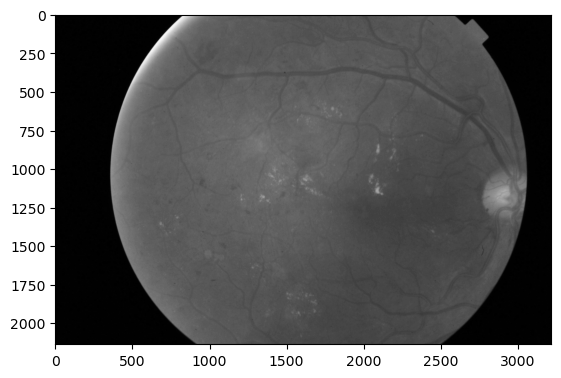

In [4]:
import matplotlib.pyplot as plt

sample_image = cv2.imread(df_train['file_path'].iloc[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(sample_image, cmap='gray')
plt.show()

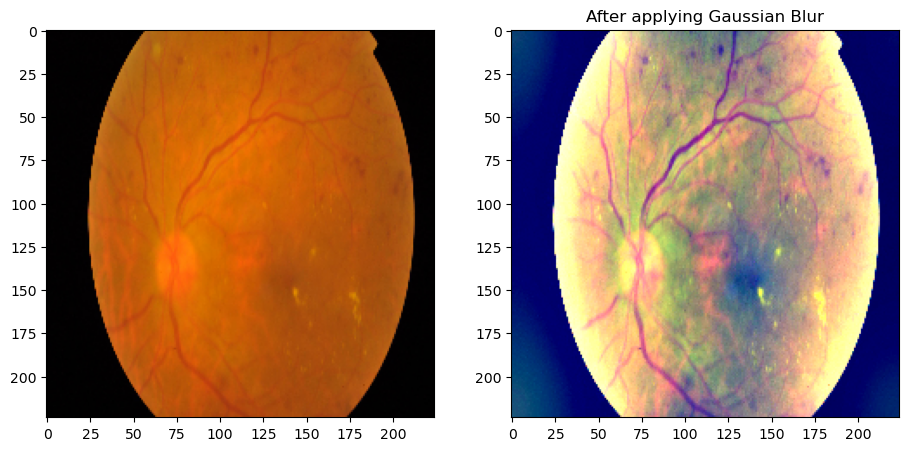

In [5]:
IMG_SIZE = 224
rn = np.random.randint(low = 0,high = len(df_train) - 1)
try:
    img = cv2.imread(df_train.file_path.iloc[rn])
    if img is None:
        print("Failed to load image")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        img_t = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 30), -4, 128)

        f, axarr = plt.subplots(1, 2, figsize=(11, 11))
        axarr[0].imshow(img)
        axarr[1].imshow(img_t)
        plt.title('After applying Gaussian Blur')
        plt.show()
except Exception as e:
    print("Error:", e)

In [6]:
import cv2
import numpy as np

def crop_image_from_gray(img, tol=7):
    # Crop image from grayscale image
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX):
    img = crop_image_from_gray(img)
    height, width, _ = img.shape
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img

def preprocess_image(img_path, save_path):
    img = cv2.imread(img_path)

    # Apply Gaussian blur
    img_processed = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 30), -4, 128)
    
    # Apply circle crop
    img_processed = circle_crop(img_processed, sigmaX=30)

    # Save the processed image
    cv2.imwrite(save_path, img_processed)


In [7]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def preprocess_image(img_path, save_path):
    img = cv2.imread(img_path)
    img_gray = conv_gray(img)

    # Apply Gaussian blur
    img_processed = cv2.addWeighted(img_gray, 4, cv2.GaussianBlur(img_gray, (0, 0), 30), -4, 128)

    # Save the processed image
    cv2.imwrite(save_path, img_processed)

In [7]:
print(df_train.head())
print(df_test.head())

        id_code diagnosis                                          file_path  \
0  000c1434d8d7         2  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
1  001639a390f0         4  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
2  0024cdab0c1e         1  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
3  002c21358ce6         0  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
4  005b95c28852         0  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
        id_code                                          file_path  \
0  0005cfc8afb6  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
1  003f0afdcd15  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
2  006efc72b638  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
3  00836aaacf06  C:/Users/venkata mohan/OneDrive/Desktop/aptos2...   
4  009245722fa4  C:/Users/venkata moh

In [9]:
import os
# Create directory if it doesn't exist
save_directory = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Iterate over DataFrame rows and preprocess images
for idx, row in df_train.iterrows():
    img_path = row['file_path']
    save_path = os.path.join(save_directory, f"{row['id_code']}.png")
    preprocess_image(img_path, save_path)


KeyboardInterrupt: 

In [9]:
save_directory = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_test_images/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
for idx, row in df_test.iterrows():
    img_path = row['file_path']
    save_path = os.path.join(save_directory, f"{row['id_code']}.png")
    preprocess_image(img_path, save_path)

In [8]:
train_images_paths = ['C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/' + row['id_code'] + '.png' for idx, row in df_train.iterrows()]
test_images_paths = ['C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_test_images/' + row['id_code'] + '.png' for idx, row in df_test.iterrows()]

In [9]:
print(train_images_paths)

['C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/000c1434d8d7.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/001639a390f0.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/0024cdab0c1e.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/002c21358ce6.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/005b95c28852.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/0083ee8054ee.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/0097f532ac9f.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images/00a8624548a9.png', 'C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/

In [10]:
def batch_image_loader(image_paths, batch_size, target_size):
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            if img is not None:  # Check if image is successfully loaded
                img_resized = cv2.resize(img, target_size)
                batch_images.append(img_resized)
        yield batch_images

def convert_images_to_numpy(image_paths, batch_size, target_size):
    numpy_images = []
    img_batch_generator = batch_image_loader(image_paths, batch_size, target_size)
    for batch in img_batch_generator:
        if batch:  # Check if batch is not empty
            batch_np = np.array(batch)
            numpy_images.append(batch_np)
    return numpy_images


In [11]:
image_directory = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_train_images"

    # List of image file paths
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'))]

batch_size = 50 
  
target_size = (224, 224)  


numpy_images = convert_images_to_numpy(image_paths, batch_size, target_size)

In [12]:
image_directory = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/preprocessed_test_images"

image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]

batch_size = 50

target_size = (224, 224) 


test_images = convert_images_to_numpy(image_paths, batch_size, target_size)

In [13]:
train_images = numpy_images

In [14]:
print(len(train_images[0]))
print(len(test_images[1]))

50
50


In [14]:
print(train_images)

[array([[[[72, 72, 72],
         [72, 72, 72],
         [72, 72, 72],
         ...,
         [36, 36, 36],
         [36, 36, 36],
         [40, 40, 40]],

        [[72, 72, 72],
         [72, 72, 72],
         [68, 68, 68],
         ...,
         [40, 40, 40],
         [36, 36, 36],
         [36, 36, 36]],

        [[72, 72, 72],
         [72, 72, 72],
         [68, 68, 68],
         ...,
         [36, 36, 36],
         [36, 36, 36],
         [40, 40, 40]],

        ...,

        [[88, 88, 88],
         [88, 88, 88],
         [92, 92, 92],
         ...,
         [68, 68, 68],
         [68, 68, 68],
         [64, 64, 64]],

        [[88, 88, 88],
         [88, 88, 88],
         [88, 88, 88],
         ...,
         [64, 64, 64],
         [64, 64, 64],
         [64, 64, 64]],

        [[88, 88, 88],
         [88, 88, 88],
         [88, 88, 88],
         ...,
         [72, 72, 72],
         [64, 64, 64],
         [68, 68, 68]]],


       [[[72, 72, 72],
         [68, 68, 68],
         [72,

In [16]:
batches = batch_image_loader(train_images_paths, 50, (224,224))

In [17]:

# Print the first two batches
for i, batch in enumerate(batches):
    print(f"Batch {i+1}:")
    for j, image in enumerate(batch):
        print(f"  Image {j+1}: {image.shape}")  
    if i == 1:
        break 


Batch 1:
  Image 1: (224, 224, 3)
  Image 2: (224, 224, 3)
  Image 3: (224, 224, 3)
  Image 4: (224, 224, 3)
  Image 5: (224, 224, 3)
  Image 6: (224, 224, 3)
  Image 7: (224, 224, 3)
  Image 8: (224, 224, 3)
  Image 9: (224, 224, 3)
  Image 10: (224, 224, 3)
  Image 11: (224, 224, 3)
  Image 12: (224, 224, 3)
  Image 13: (224, 224, 3)
  Image 14: (224, 224, 3)
  Image 15: (224, 224, 3)
  Image 16: (224, 224, 3)
  Image 17: (224, 224, 3)
  Image 18: (224, 224, 3)
  Image 19: (224, 224, 3)
  Image 20: (224, 224, 3)
  Image 21: (224, 224, 3)
  Image 22: (224, 224, 3)
  Image 23: (224, 224, 3)
  Image 24: (224, 224, 3)
  Image 25: (224, 224, 3)
  Image 26: (224, 224, 3)
  Image 27: (224, 224, 3)
  Image 28: (224, 224, 3)
  Image 29: (224, 224, 3)
  Image 30: (224, 224, 3)
  Image 31: (224, 224, 3)
  Image 32: (224, 224, 3)
  Image 33: (224, 224, 3)
  Image 34: (224, 224, 3)
  Image 35: (224, 224, 3)
  Image 36: (224, 224, 3)
  Image 37: (224, 224, 3)
  Image 38: (224, 224, 3)
  Image 39: 

In [18]:
from tensorflow.keras.applications import ResNet50, InceptionV3

# Load pre-trained ResNet50 and InceptionV3 models without top layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [16]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
inception_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [19]:
def extract_features_from_batches(batches):
    resnet_features_list = []
    inception_features_list = []
    
    for batch in batches:
        images = np.array(batch).astype('float32') / 255.0
        resnet_features = resnet_model.predict(images)
        inception_features = inception_model.predict(images)
        resnet_features_list.append(resnet_features)
        inception_features_list.append(inception_features)
    
    resnet_features_concat = np.concatenate(resnet_features_list, axis=0)
    inception_features_concat = np.concatenate(inception_features_list, axis=0)
    
    return resnet_features_concat, inception_features_concat


In [20]:
resnet_features, inception_features = extract_features_from_batches(numpy_images)


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 697ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 717ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3

In [29]:
resnet_features_test, inception_features_test = extract_features_from_batches(test_images)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 738ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 732ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 734ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
from skimage.transform import resize
resnet_features= resize(resnet_features, (3662, 5, 5, 2048))

In [22]:
print("ResNet Features Shape:", resnet_features.shape)
print("Inception Features Shape:", inception_features.shape)

ResNet Features Shape: (3662, 5, 5, 2048)
Inception Features Shape: (3662, 5, 5, 2048)


In [23]:
combined_features = np.concatenate((resnet_features,inception_features), axis=-1)
print(combined_features.shape)


(3662, 5, 5, 4096)


In [24]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/train.csv"
df = pd.read_csv(csv_file_path)

labels = df['diagnosis'].tolist()
print(len(labels))

3662


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = "C:/Users/venkata mohan/OneDrive/Desktop/aptos2019-blindness-detection/test.csv"
df = pd.read_csv(csv_file_path)

labels = df['diagnosis'].tolist()
print(len(labels))

In [25]:
combined_features = np.array(combined_features, dtype=np.float32)

In [26]:
print(combined_features.shape[3])

4096


In [27]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Flatten layer
    layers.Flatten(input_shape=(5, 5, 4096)),
    
    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    
    # Output layer
    layers.Dense(5, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


C:\Users\venkata mohan\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      52,429,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,561,925 (200.51 MB)

 Trainable params: 52,561,925 (200.51 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import tensorflow as tf
labels = np.array(labels)  # Assuming labels are integer-encoded

# Create a TensorFlow dataset from the NumPy arrays
dataset = tf.data.Dataset.from_tensor_slices((combined_features, labels))

batch_size = 32
epochs = 20
dataset = dataset.shuffle(buffer_size=len(combined_features)).batch(batch_size)

# Iterate over the dataset for 100 epochs
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for batch_features, batch_labels in dataset:
   
        model.fit(batch_features, batch_labels, verbose=0) 
    
    # Evaluate the model on the entire dataset
    train_loss, train_accuracy = model.evaluate(dataset, verbose=0)
    print(f'Gross Accuracy: {train_accuracy}')


Epoch 1/20
Gross Accuracy: 0.6209721565246582
Epoch 2/20
Gross Accuracy: 0.835608959197998
Epoch 3/20
Gross Accuracy: 0.7332059144973755
Epoch 4/20
Gross Accuracy: 0.8588203191757202
Epoch 5/20
Gross Accuracy: 0.934188961982727
Epoch 6/20
Gross Accuracy: 0.951938807964325
Epoch 7/20
Gross Accuracy: 0.96750408411026
Epoch 8/20
Gross Accuracy: 0.9251775145530701
Epoch 9/20
Gross Accuracy: 0.8317859172821045
Epoch 10/20
Gross Accuracy: 0.9156198501586914
Epoch 11/20
Gross Accuracy: 0.8730202317237854
Epoch 12/20
Gross Accuracy: 0.9776078462600708
Epoch 13/20
Gross Accuracy: 0.9631348848342896
Epoch 14/20
Gross Accuracy: 0.9117968082427979
Epoch 15/20
Gross Accuracy: 0.9814308881759644
Epoch 16/20
Gross Accuracy: 0.9696887135505676
Epoch 17/20
Gross Accuracy: 0.9852539300918579
Epoch 18/20
Gross Accuracy: 0.951938807964325
Epoch 19/20
Gross Accuracy: 0.9803386330604553
Epoch 20/20
Gross Accuracy: 0.9830693602561951


In [30]:
import tensorflow as tf
labels = np.array(labels)  # Assuming labels are integer-encoded

# Create a TensorFlow dataset from the NumPy arrays

train_features, test_features, train_labels, test_labels = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
batch_size = 32
epochs = 20
train_dataset = train_dataset.shuffle(buffer_size=len(train_features)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Iterate over the dataset for 100 epochs
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for batch_features, batch_labels in train_dataset:
   
        model.fit(batch_features, batch_labels, verbose=0) 
    
    # Evaluate the model on the entire dataset
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)
    print(f'Gross Accuracy: {train_accuracy}')


Epoch 1/20
Gross Accuracy: 0.9617617130279541
Epoch 2/20
Gross Accuracy: 0.9675657153129578
Epoch 3/20
Gross Accuracy: 0.9115738868713379
Epoch 4/20
Gross Accuracy: 0.8603618741035461
Epoch 5/20
Gross Accuracy: 0.9846363663673401
Epoch 6/20
Gross Accuracy: 0.9723455309867859
Epoch 7/20
Gross Accuracy: 0.9911232590675354
Epoch 8/20
Gross Accuracy: 0.983953595161438
Epoch 9/20
Gross Accuracy: 0.9262546896934509
Epoch 10/20
Gross Accuracy: 0.9883919358253479
Epoch 11/20
Gross Accuracy: 0.9897575974464417
Epoch 12/20
Gross Accuracy: 0.9918060898780823
Epoch 13/20
Gross Accuracy: 0.9897575974464417
Epoch 14/20
Gross Accuracy: 0.975418210029602
Epoch 15/20
Gross Accuracy: 0.9866848587989807
Epoch 16/20
Gross Accuracy: 0.987709105014801
Epoch 17/20
Gross Accuracy: 0.9842950105667114
Epoch 18/20
Gross Accuracy: 0.9819051027297974
Epoch 19/20
Gross Accuracy: 0.987709105014801
Epoch 20/20
Gross Accuracy: 0.9696142077445984


In [35]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8498 - loss: 0.5130
Test Loss: 0.4986347258090973
Test Accuracy: 0.8553888201713562


In [49]:
# Save the model
model.save("diabetic.h5")


In [48]:
import os

os.chdir("D:\\")
print(os.getcwd())

D:\


In [50]:
# Load the model
loaded_model = tf.keras.models.load_model("D:\diabetic.h5")

In [51]:
train_loss, train_accuracy = loaded_model.evaluate(dataset, verbose=0)
print(train_loss)
print(train_accuracy)

0.2891502380371094
0.8877662420272827
